聚类

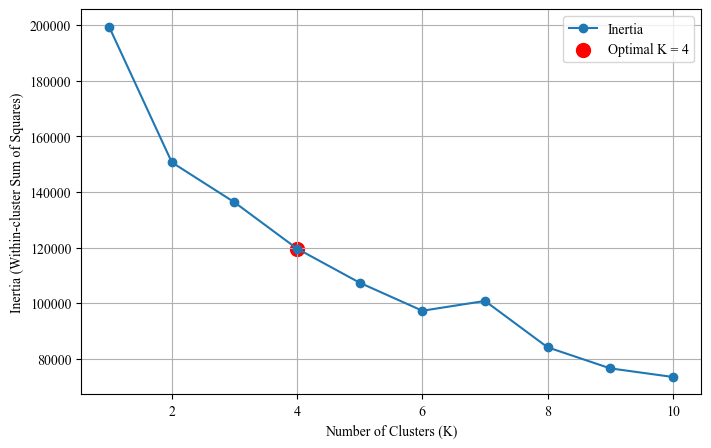

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
plt.rcParams['font.family'] = 'Times New Roman'
# Load Excel data
df = pd.read_excel(r'./1XAI_聚类.xlsx',sheet_name='数据原始')

# Select numeric columns for clustering
features = df.select_dtypes(include=['float64', 'int64'])

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Use Elbow Method to find the optimal number of clusters
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# ---------- 自动检测“肘部” ----------
# 计算每个点到直线（K=1到K=10）之间的垂直距离，找最大值点作为最佳 K
x = np.array(list(K_range))
y = np.array(inertia)
point1 = np.array([x[0], y[0]])
point2 = np.array([x[-1], y[-1]])
line_vec = point2 - point1
line_vec_norm = line_vec / np.linalg.norm(line_vec)
vec_from_first = np.vstack([x, y]).T - point1
scalar_product = np.dot(vec_from_first, line_vec_norm)
proj = np.outer(scalar_product, line_vec_norm)
dist_to_line = np.linalg.norm(vec_from_first - proj, axis=1)
optimal_k = x[np.argmax(dist_to_line)]

# ---------- 绘图 ----------
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', label='Inertia')
plt.scatter(optimal_k, inertia[optimal_k - 1], color='red', s=100, label=f'Optimal K = {optimal_k}')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.legend()
plt.grid(True)
plt.show()


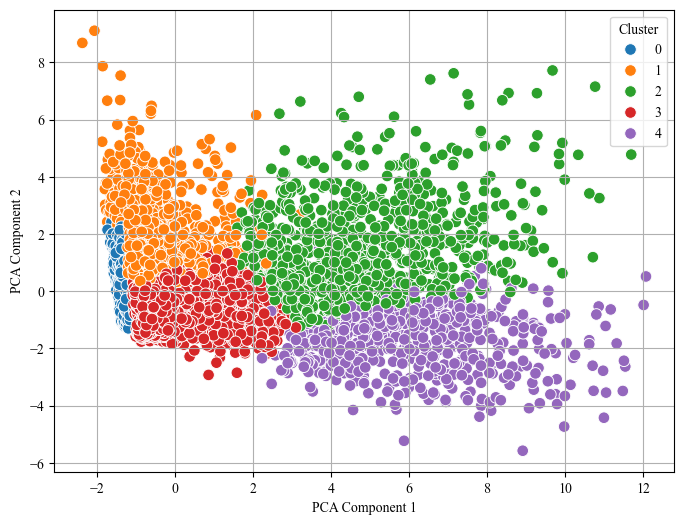

In [138]:
from sklearn.decomposition import PCA
import seaborn as sns

# Step 1: Run KMeans using the optimal K
kmeans = KMeans(n_clusters=5,n_init='auto')
cluster_labels = kmeans.fit_predict(scaled_features)

# Add cluster label to original DataFrame
df['cluster'] = cluster_labels

# Step 2: Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Step 3: Plot with seaborn
plt.figure(figsize=(8, 6))
# Step 1: 定义固定颜色映射
fixed_palette = {
    0: '#1f77b4',  # 蓝色
    1: '#ff7f0e',  # 橙色
    2: '#2ca02c',  # 绿色
    3: '#d62728',  # 红色
    4: '#9467bd',  # 紫色
}

# Step 2: 画图，palette 用字典
sns.scatterplot(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    hue=cluster_labels,
    palette=fixed_palette,
    s=70
)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

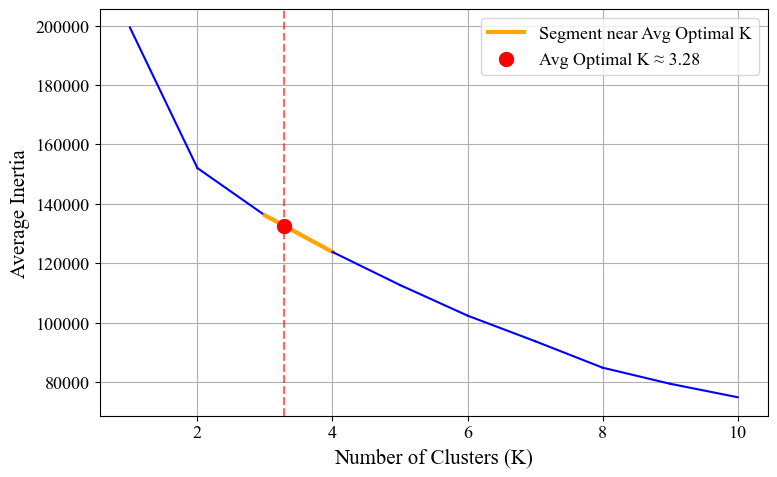

Optimal K frequency over 50 runs:
K = 2: 5 times
K = 3: 33 times
K = 4: 5 times
K = 5: 7 times

Average optimal K: 3.28


In [156]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from collections import Counter
from scipy.interpolate import interp1d

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['legend.fontsize'] = 13
# Load Excel data
df = pd.read_excel(r'./1XAI_聚类.xlsx', sheet_name='数据原始')

# Select numeric columns for clustering
features = df.select_dtypes(include=['float64', 'int64'])

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Repeat clustering
n_repeats = 50
K_range = range(1, 11)
all_inertias = []
optimal_ks = []

for _ in range(n_repeats):
    inertia = []
    for k in K_range:
        kmeans = KMeans(n_clusters=k, n_init='auto')
        kmeans.fit(scaled_features)
        inertia.append(kmeans.inertia_)
    all_inertias.append(inertia)

    # Compute elbow
    x = np.array(list(K_range))
    y = np.array(inertia)
    point1 = np.array([x[0], y[0]])
    point2 = np.array([x[-1], y[-1]])
    line_vec = point2 - point1
    line_vec_norm = line_vec / np.linalg.norm(line_vec)
    vec_from_first = np.vstack([x, y]).T - point1
    scalar_product = np.dot(vec_from_first, line_vec_norm)
    proj = np.outer(scalar_product, line_vec_norm)
    dist_to_line = np.linalg.norm(vec_from_first - proj, axis=1)
    optimal_k = x[np.argmax(dist_to_line)]
    optimal_ks.append(optimal_k)

# Compute averages
avg_inertia = np.mean(all_inertias, axis=0)
avg_optimal_k = np.mean(optimal_ks)

# Prepare interpolation to get y-value for floating-point x
interp_func = interp1d(K_range, avg_inertia, kind='linear')
y_interp = interp_func(avg_optimal_k)

# Identify the segment near avg_optimal_k
lower_k = int(np.floor(avg_optimal_k))
upper_k = int(np.ceil(avg_optimal_k))

# ---------- Plot ----------
plt.figure(figsize=(8, 5))

# Plot all segments, coloring the segment near avg_optimal_k differently
for i in range(len(K_range) - 1):
    k1, k2 = K_range[i], K_range[i + 1]
    y1, y2 = avg_inertia[i], avg_inertia[i + 1]
    if k1 == lower_k and k2 == upper_k:
        plt.plot([k1, k2], [y1, y2], color='orange', linewidth=3, label='Segment near Avg Optimal K')
    else:
        plt.plot([k1, k2], [y1, y2], color='blue')

# Plot the interpolated red point
plt.scatter(avg_optimal_k, y_interp, color='red', s=100, zorder=5,
            label=f'Avg Optimal K ≈ {avg_optimal_k:.2f}')

# Vertical dashed red line at avg_optimal_k
plt.axvline(x=avg_optimal_k, color='red', linestyle='--', alpha=0.6)

# Formatting
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Inertia')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Print optimal K stats ----------
optimal_k_counts = Counter(optimal_ks)
print("Optimal K frequency over", n_repeats, "runs:")
for k, count in sorted(optimal_k_counts.items()):
    print(f"K = {k}: {count} times")

print("\nAverage optimal K:", round(avg_optimal_k, 2))


In [119]:
df['cluster'].value_counts().sort_index()

cluster
0    9857
1     993
2     590
3       2
4    3899
Name: count, dtype: int64

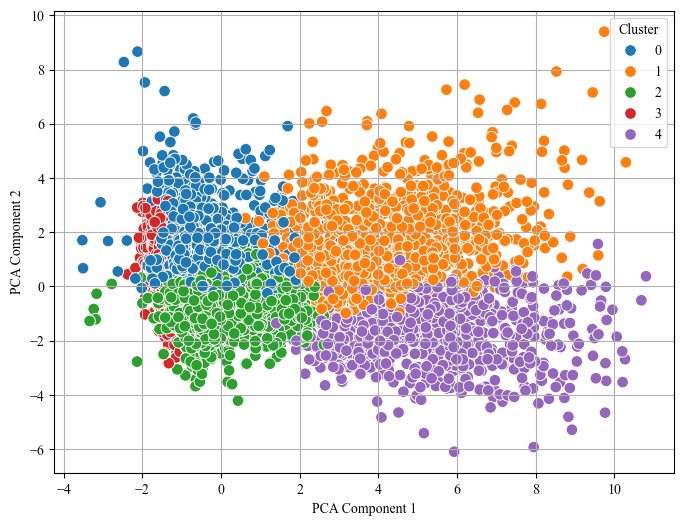

In [143]:
from sklearn.decomposition import PCA
import seaborn as sns

# Step 1: Run KMeans using the optimal K
kmeans = KMeans(n_clusters=5, n_init='auto')
cluster_labels = kmeans.fit_predict(scaled_features)

# Add cluster label to original DataFrame
df2['cluster'] = cluster_labels

# Step 2: Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Step 3: Plot with seaborn
plt.figure(figsize=(8, 6))
# Step 1: 定义固定颜色映射
fixed_palette = {
    0: '#1f77b4',  # 蓝色
    1: '#ff7f0e',  # 橙色
    2: '#2ca02c',  # 绿色
    3: '#d62728',  # 红色
    4: '#9467bd',  # 紫色
}

# Step 2: 画图，palette 用字典
sns.scatterplot(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    hue=cluster_labels,
    palette=fixed_palette,
    s=70
)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [148]:
cluster_labels
pd.DataFrame({'cluster': cluster_labels}).to_excel('./cluster_labels.xlsx', index=False)

In [153]:
cluster_labels=pd.read_excel(r'./cluster_labels.xlsx')
cluster_labels = cluster_labels['cluster'].values
cluster_labels

array([1, 1, 4, ..., 3, 3, 2], dtype=int64)

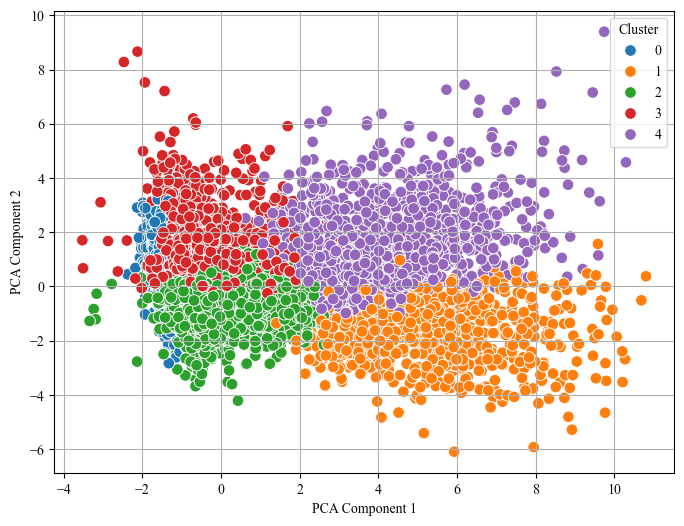

In [155]:
# Step 3: Plot with seaborn
plt.figure(figsize=(8, 6))
# Step 1: 定义固定颜色映射
fixed_palette = {
    3: '#d62728',  # 蓝色
    4: '#9467bd',  # 橙色
    2: '#2ca02c',  # 绿色
    0: '#1f77b4',  # 红色
    1: '#ff7f0e',  # 紫色
}

# Step 2: 画图，palette 用字典
sns.scatterplot(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    hue=cluster_labels,
    palette=fixed_palette,
    s=70
)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [85]:
df2['cluster'].value_counts().sort_index()

cluster
0    2558
1    1937
2    2311
3    6577
4    2699
Name: count, dtype: int64